In [0]:
import pandas as pd
import datetime
import numpy as np
import random
import re
import scipy
import collections
import matplotlib.pyplot as plt
# %matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

Подход к решению задачи по прогнозированию покупок беременных. Тестовое задание к хакатону от Х5. Испольнитель Бочаров А.М. скайп bam271074

Прогнозирование детских покупок можно сделать на основании покупок, которые женщина делает во время беременности. Известно, что в период беременности женщина нуждается в витаминах и фолиевой кислоте. Таким образом если женщина возраста от 16 до 40 лет часто покупает овощи, фрукты, овес, постное мясо, молочные изделия. На основании данной информации можно построить модель, обучить ее выявлять данную закономерность и использовать в работе.

In [0]:
pip list

Package                  Version        
------------------------ ---------------
absl-py                  0.9.0          
alabaster                0.7.12         
albumentations           0.1.12         
altair                   4.1.0          
asgiref                  3.2.7          
astor                    0.8.1          
astropy                  4.0.1.post1    
astunparse               1.6.3          
atari-py                 0.2.6          
atomicwrites             1.4.0          
attrs                    19.3.0         
audioread                2.1.8          
autograd                 1.3            
Babel                    2.8.0          
backcall                 0.1.0          
beautifulsoup4           4.6.3          
bleach                   3.1.5          
blis                     0.4.1          
bokeh                    1.4.0          
boto                     2.49.0         
boto3                    1.13.13        
botocore                 1.16.13        
Bottleneck      

### Версии:

- `numpy`: 1.18.4
- `pandas`: 1.0.3
- `sklearn`: 0.21.3

# загрузим сгенерированный датасет и обучим классификатор

In [0]:
#let s fix random state
value = 42
random.seed(value)
np.random.seed(value)

In [3]:
#let s upload file with dataset pokupty20000.csv
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print ('User uploaded file {name} with length {length} bytes'.format(name=fn, \
                                                                       length=len(uploaded[fn])))

Saving pokupty20000.csv to pokupty20000.csv
User uploaded file pokupty20000.csv with length 722811 bytes


In [6]:
data_df=pd.read_csv('pokupty20000.csv')
data_df.head()

,Client,Products,Target
0,Sophy,Fries Onion Milk,positive
1,Filona,Sweet Vine Water,negative
2,Sophy,Cheese Salt Eris,positive
3,Alla,Cigar Eris Salo,negative
4,Hilary,Water Iogurt Beer,positive


In [12]:
X=data_df.Products
y=data_df.Target
X.head()

0     Fries Onion Milk
1     Sweet Vine Water
2     Cheese Salt Eris
3      Cigar Eris Salo
4    Water Iogurt Beer
Name: Products, dtype: object

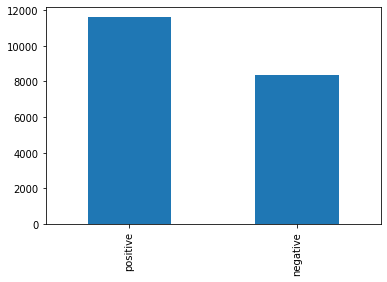

In [7]:
data_df.Target.value_counts().plot(kind='bar')

In [0]:
TOKEN_RE = re.compile(r'[\w\d]+')  #regular expression to start with

In [0]:
def tokenize_text_simple_regex(txt, min_token_size=2):
    """ This func tokenize text with TOKEN_RE applied ealier """
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]

def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
    """
    This func tokenize corpus of docs
    """
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]

In [13]:
text_tokenized = tokenize_corpus(X)

print(text_tokenized)

[['fries', 'onion', 'milk'], ['sweet', 'vine', 'water'], ['cheese', 'salt', 'eris'], ['cigar', 'eris', 'salo'], ['water', 'iogurt', 'beer'], ['fries', 'vine', 'sweet'], ['salo', 'cream', 'bananas'], ['bananas', 'eris', 'iogurt'], ['bread', 'onion', 'cream'], ['eris', 'pepper', 'sugar'], ['kefir', 'beer', 'water'], ['salt', 'cheese', 'cream'], ['iogurt', 'cream', 'bananas'], ['beer', 'water', 'abritos'], ['vine', 'milk', 'salt'], ['cigar', 'salo', 'pepper'], ['bananas', 'kefir', 'cream'], ['sweet', 'onion', 'salt'], ['iogurt', 'vodka', 'vine'], ['pepper', 'cheese', 'salt'], ['cream', 'water', 'fries'], ['vine', 'onion', 'sugar'], ['water', 'salt', 'bread'], ['vine', 'salt', 'pepper'], ['abritos', 'pepper', 'bread'], ['kefir', 'cream', 'bananas'], ['bread', 'milk', 'pepper'], ['sweet', 'cheese', 'onion'], ['sweet', 'fries', 'bread'], ['fries', 'pepper', 'iogurt'], ['fries', 'sugar', 'abritos'], ['cheese', 'vodka', 'milk'], ['abritos', 'bread', 'iogurt'], ['vodka', 'cheese', 'salt'], ['vo

In [0]:
def build_vocabulary(tokenized_texts, max_size=100_000, max_doc_freq=1.0, min_count=1, pad_word=None):
    """ This func builds vocabulary """
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq


In [15]:
# строим словарь
vocabulary, word_doc_freq = build_vocabulary(text_tokenized, max_doc_freq=1.0, min_count=1)
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:20])

Размер словаря 21
[('iogurt', 0), ('onion', 1), ('sweet', 2), ('milk', 3), ('water', 4), ('salt', 5), ('sugar', 6), ('fries', 7), ('kefir', 8), ('beer', 9), ('vine', 10), ('salo', 11), ('cigar', 12), ('pepper', 13), ('abritos', 14), ('vodka', 15), ('bananas', 16), ('cheese', 17), ('bread', 18), ('eris', 19)]


In [0]:
def vectorize_texts(tokenized_texts, word2id, word2freq, mode='tfidf', scale=True):
    """ This func vectorize texts """
    assert mode in {'ltfidf', 'tfidf', 'idf', 'tf', 'bin'}
    # ltfidf is ln(TF+1)*IDF
    # считаем количество употреблений каждого слова в каждом документе
    result = scipy.sparse.dok_matrix((len(tokenized_texts), len(word2id)), dtype='float32')
    for text_i, text in enumerate(tokenized_texts):
        for token in text:
            if token in word2id:
                result[text_i, word2id[token]] += 1  #add 1 to element of matrix

    # получаем бинарные вектора "встречается или нет"
    if mode == 'bin':
        result = (result > 0).astype('float32')

    # получаем вектора относительных частот слова в документе
    elif mode == 'tf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))
    # учитываем всю информацию, которая у нас есть:
    # частоту слова в документе и частоту слова в корпусе
    elif mode == 'tfidf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))  # разделить каждую строку на её длину
        result = result.multiply(1 / word2freq)  # разделить каждый столбец на вес слова
    elif mode == 'ltfidf':
        result = result.tocsr()
        result = result.multiply(1 / result.sim(1))  # divide string to its len
        one_array = np.ones(len(tokenized_texts), len(word2id))
        result = np.log(result + one_array)
        result = result.multiply( 1 / word2freq)

    if scale:
        #result = result.tocsc()
        #result = result.std(0, ddof = 1)
        result = result.tocsc()
        result -= result.min()
        result /= (result.max() + 1e-6)

    return result.tocsr()


In [0]:
VECTORIZATION_MODE = 'tfidf'
train_vectors = vectorize_texts(text_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)


In [21]:
print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)

Размерность матрицы признаков обучающей выборки (20000, 21)


In [25]:
clf = GradientBoostingClassifier(random_state=value)
clf.fit(train_vectors, y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [28]:

print(train_vectors[:1])

  (0, 1)	0.94975865
  (0, 3)	0.9527093
  (0, 7)	0.96100235


1-onion  3-milk   7-fries

In [29]:
clf.predict(train_vectors[:1])

array(['positive'], dtype=object)

в выборке есть молоко, и классификатор правильно это определил

In [27]:
clf.score(train_vectors, y)

1.0